In [4]:
%matplotlib notebook
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy import interpolate
from scipy.interpolate import interp1d

# Load the data

In [5]:
corona = pd.read_csv(os.path.join("data", "effective_area", 'corona.csv'),index_col=0)
jet = pd.read_csv(os.path.join("data", "effective_area", 'jet.csv'),index_col=0)
wind = pd.read_csv(os.path.join("data", "effective_area", 'wind.csv'),index_col=0)
Aeff_ehe = pd.read_csv(os.path.join("data", "effective_area", 'Aeff_ehe_gfu.csv'),names=('E_Tev','Aeff_m2')).apply(lambda x: np.log10(x))
print(corona)

     log10E_GeV  E2_Fmu_GeV
0      0.928474   -7.570574
1      0.990974   -7.479767
2      1.053473   -7.389325
3      1.115974   -7.299420
4      1.178473   -7.209917
..          ...         ...
107    7.615973        -inf
108    7.678473        -inf
109    7.740974        -inf
110    7.803473        -inf
111    7.865973        -inf

[112 rows x 2 columns]


<IPython.core.display.Javascript object>


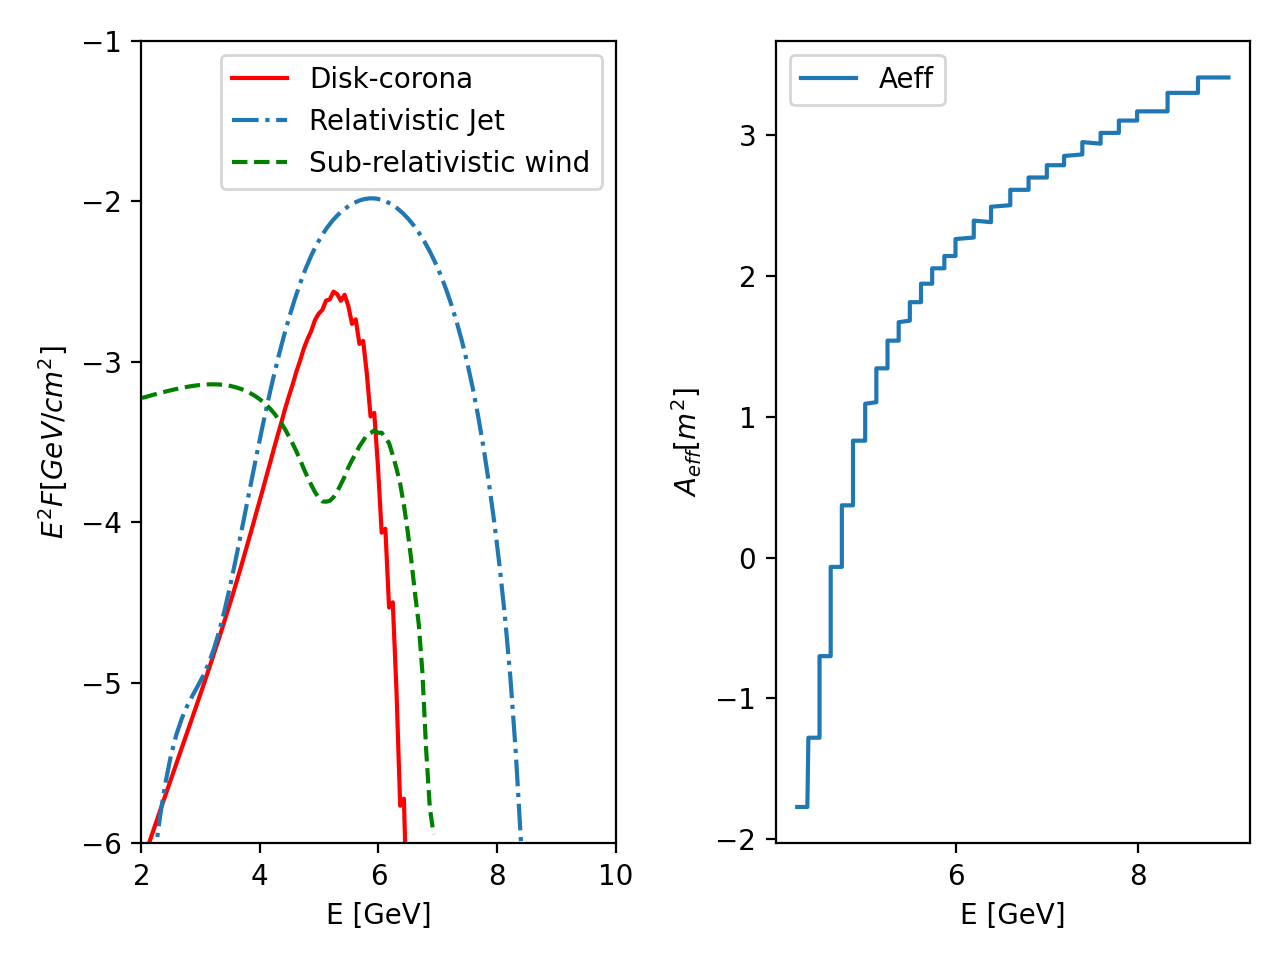

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(corona['log10E_GeV'],corona['E2_Fmu_GeV'],'r',label='Disk-corona')
ax1.plot(jet['log10E_GeV'],jet['E2_Fmu_GeV'],linestyle='dashdot',label='Relativistic Jet')
ax1.plot(wind['log10E_GeV'],wind['E2_Fmu_GeV'],'g--',label='Sub-relativistic wind')
ax2.plot(Aeff_ehe['E_Tev']+3,Aeff_ehe['Aeff_m2'],label='Aeff')

ax1.legend()
ax2.legend()
ax1.axis([2,10,-6,-1])
# ax2.axis([2,10,-2,3])
plt.show()
ax1.set_xlabel('E [GeV]')
ax2.set_xlabel('E [GeV]')
ax1.set_ylabel('$E^{2}F [GeV/cm^{2}]$')
ax2.set_ylabel('$A_{eff} [m^{2}]$')
plt.tight_layout()
plt.savefig('figure.jpg')

# Calculate $F_{\nu}$
UNIT ALERT: this is switching from area in $cm^{2}$ to $m^{2}$

In [8]:
Model = corona
Model['Fmu_m-2GeV-1'] = np.log10((1/1e-4)*(10**Model['E2_Fmu_GeV']/((10**Model['log10E_GeV'])**2)))

/Users/simeon/.pyenv/versions/3.8.9/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Interpolate the data

<IPython.core.display.Javascript object>


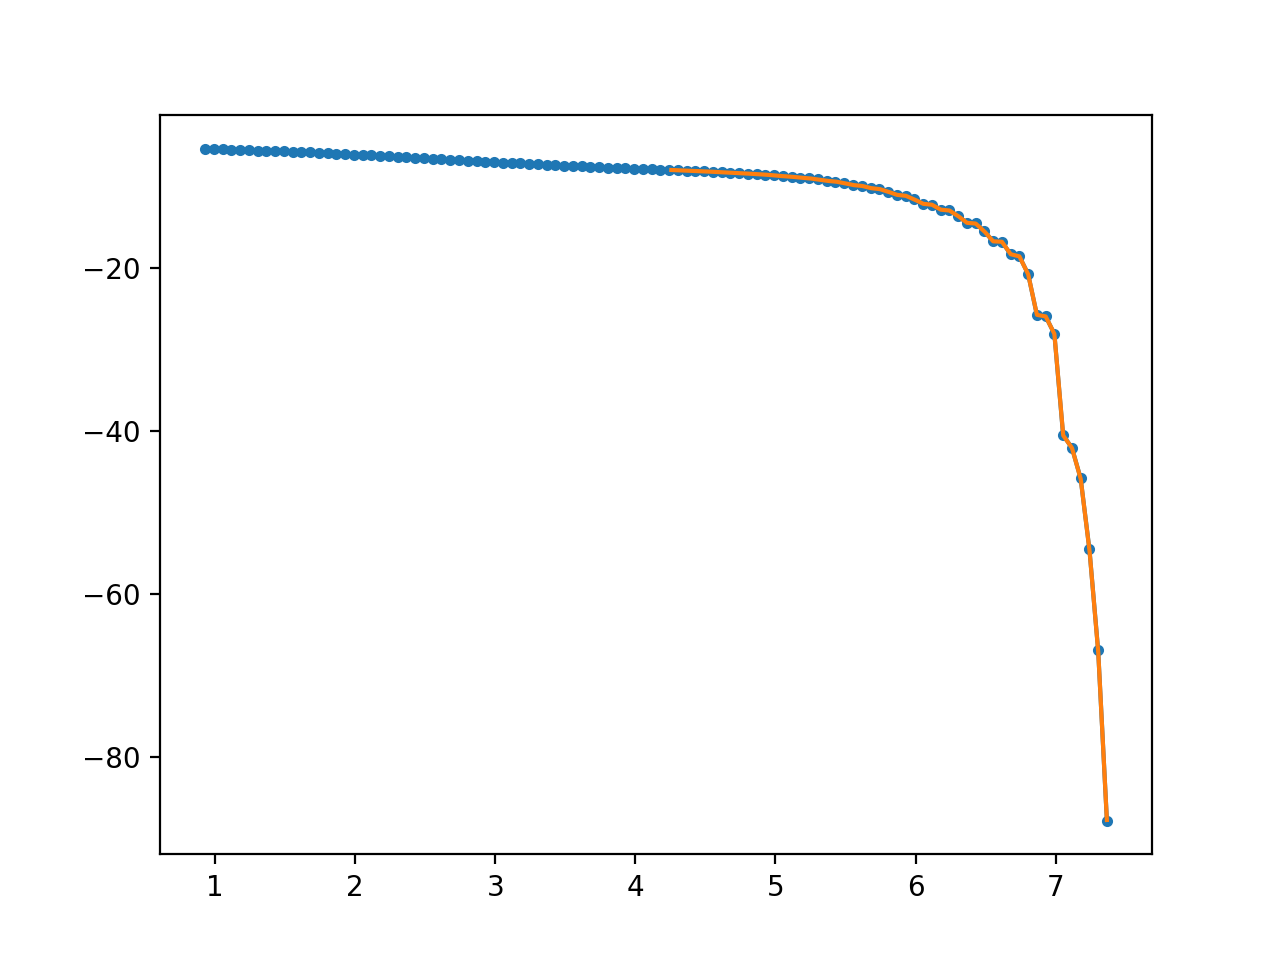

In [9]:
f = interp1d(Model['log10E_GeV'],Model['Fmu_m-2GeV-1'])

maxlog = np.max(Model['log10E_GeV'])
minlog = np.min(Aeff_ehe['E_Tev']+3)
xnew = np.linspace(minlog,maxlog,10000)

plt.figure(5)
plt.plot(Model['log10E_GeV'],Model['Fmu_m-2GeV-1'],marker='.')
plt.plot(xnew,f(xnew))
plt.show()

<IPython.core.display.Javascript object>


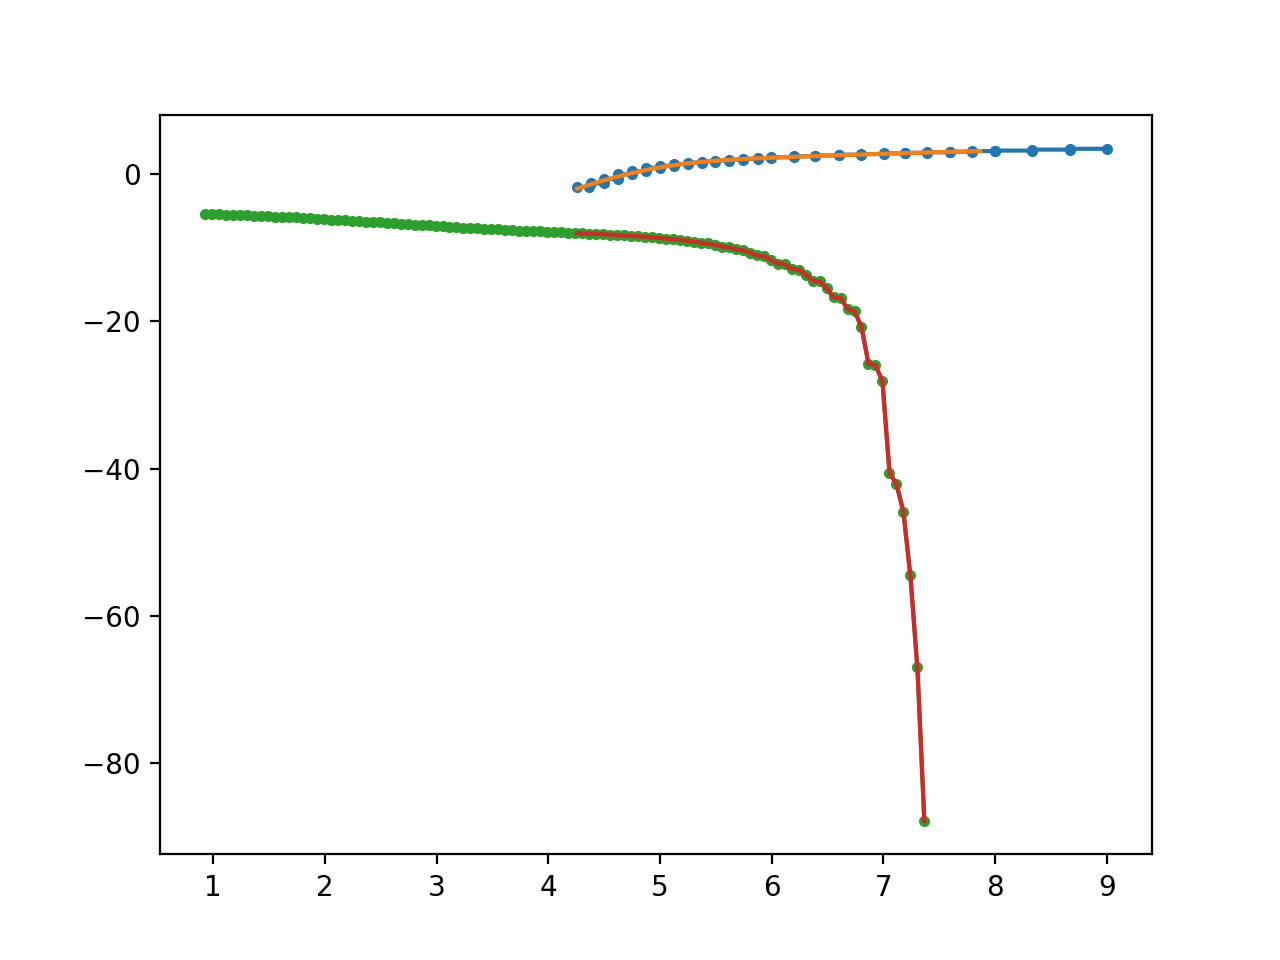

In [10]:
tck = interpolate.splrep(Aeff_ehe['E_Tev']+3,Aeff_ehe['Aeff_m2'],s=1)

maxpoint = np.min([np.max(Aeff_ehe['E_Tev']+3),np.max(Model['log10E_GeV'])])
xnew = np.linspace(np.min(Aeff_ehe['E_Tev']+3),maxpoint,100000)
Aeff = interpolate.splev(xnew, tck)

plt.figure(4)
plt.plot(Aeff_ehe['E_Tev']+3,Aeff_ehe['Aeff_m2'],marker='.')
plt.plot(xnew,Aeff)
plt.plot(Model['log10E_GeV'],Model['Fmu_m-2GeV-1'],marker='.')
plt.plot(xnew,f(xnew))
plt.show()

# Calculate N using $\int{F_{\nu}A_{eff}dE}$

In [595]:
N = np.trapz((10**f(xnew))*(10**Aeff),x=10**xnew)
print(N)

0.0010352149612917172


# Assemble it all into a function

In [11]:
def calculate_N(Aeff,Model,model_flux_col='E2_Fmu_GeV',model_E_col='log10E_GeV',aeff_colE='E_Tev',aeff_colm2='Aeff_m2'):
    """
    A function to calculate the number of Neutrino events from a model source.
    parameters:
        Aeff - the effective area dataset in m^{2} per energy in in TeV 
        Model - the model data set in E^{2} F_{\nu} in GeV per cm^2 per energy in GeV in log10 space
        model_flux_col - the model flux column name
        model_E_col - the model energy column name
        aeff_colE - the effective area energy column name
        aeff_colm2 - the effective area area column name
        
    Last update: 10 November 2021
    """
    
    Model['Fmu_m-2GeV-1'] = np.log10((1/1e-4)*(10**Model[model_flux_col]/((10**Model[model_E_col])**2)))
    
    f_nu_interp = interp1d(Model[model_E_col],Model['Fmu_m-2GeV-1'])
    tck = interpolate.splrep(Aeff[aeff_colE]+3,Aeff[aeff_colm2],s=1)
    
    maxpoint = np.min([np.max(Aeff[aeff_colE]+3),np.max(Model[model_E_col])])
    minpoint = np.max([np.min(Aeff[aeff_colE]+3),np.min(Model[model_E_col])])
    xnew = np.linspace(minpoint,maxpoint,100000)
    Aeff_interp = interpolate.splev(xnew, tck)
    
    N = np.trapz((10**f_nu_interp(xnew))*(10**Aeff_interp),x=10**xnew)
    return N

In [12]:
print(calculate_N(Aeff_ehe,corona),calculate_N(Aeff_ehe,jet),calculate_N(Aeff_ehe,wind))

0.007211096946394897 0.0567852671813144 0.0014111991706831732


/Users/simeon/.pyenv/versions/3.8.9/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
